<a href="https://colab.research.google.com/github/0xTheFool/FER/blob/main/FER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install kaggle

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"parasb1ank","key":"017cb8391dcf63b0f3e76e3b1d80e5f2"}'}

In [8]:
! mkdir ~/.kaggle

In [9]:
! cp kaggle.json ~/.kaggle/

In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d msambare/fer2013

 68% 41.0M/60.3M [00:00<00:00, 213MB/s]
100% 60.3M/60.3M [00:00<00:00, 189MB/s]


In [12]:
import zipfile
zip_ref = zipfile.ZipFile('fer2013.zip', 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [1]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
img_array = cv2.imread("dataset/train/angry/Training_10118481.jpg")

In [3]:
img_array.shape # RGB

(48, 48, 3)

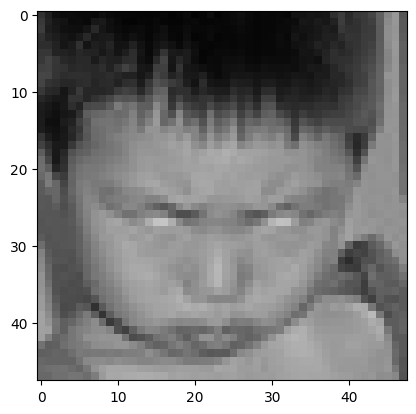

In [4]:
plt.imshow(img_array)

In [5]:
Training_DataFolder = "dataset/train"
Test_DataFolder = "dataset/test"

In [6]:
Classes = ["angry","disgust","fear","happy","neutral","sad","surprise"]

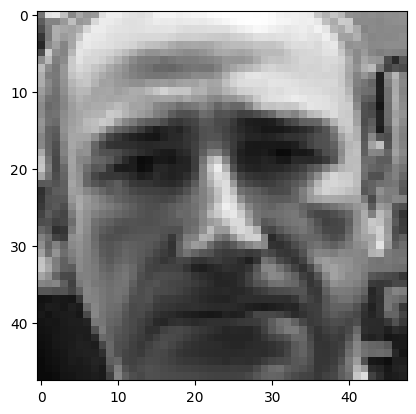

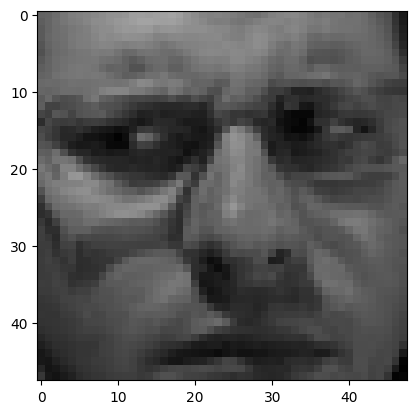

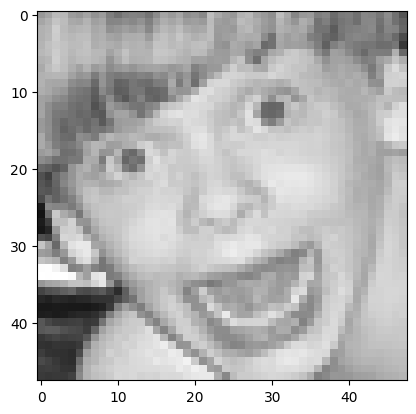

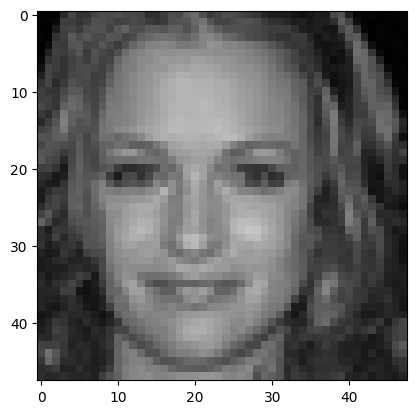

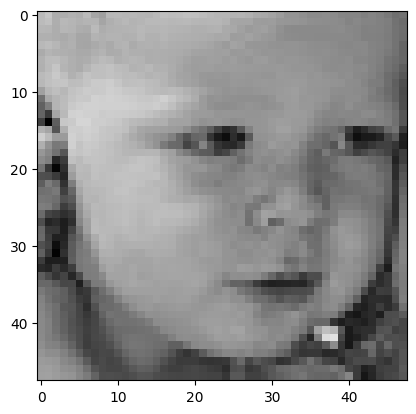

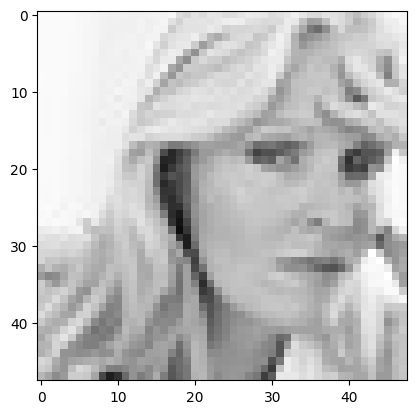

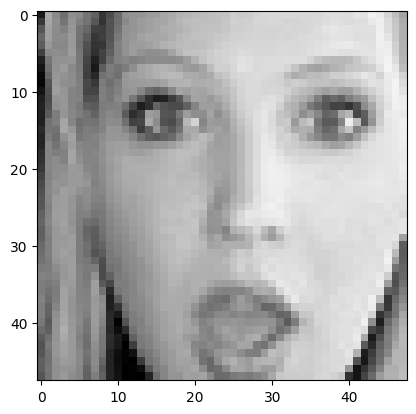

In [7]:
for emotion in Classes:
    path = os.path.join(Training_DataFolder, emotion)
    for img in os.listdir(path):
        img_arr = cv2.imread(os.path.join(path, img))
        plt.imshow(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB))
        plt.show()
        break


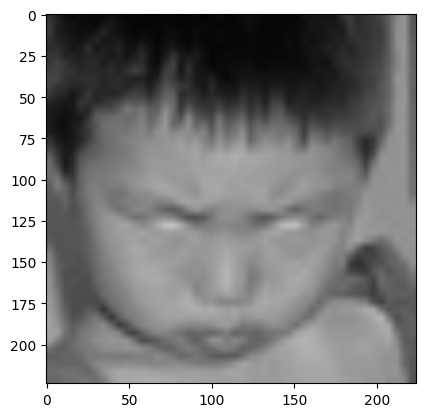

(224, 224, 3)

In [8]:
img_size = 224 # ImageNet or other models require 224x244 input
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
plt.show()
new_array.shape

In [9]:
training_data = []
test_data = []
img_size = 224
def create_training_data():
    for emotion in Classes:
        path = os.path.join(Training_DataFolder, emotion)
        class_index = Classes.index(emotion)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                new_arr = cv2.resize(img_arr, (img_size,img_size))
                training_data.append([new_arr,class_index])

            except Exception as e:
                pass
def create_test_data():
    for emotion in Classes:
        path = os.path.join(Test_DataFolder, emotion)
        class_index = Classes.index(emotion)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                new_arr = cv2.resize(img_arr, (img_size,img_size))
                test_data.append([new_arr,class_index])

            except Exception as e:
                pass


In [10]:
create_training_data()
create_test_data()

In [11]:
len(training_data)

28709

In [12]:
len(test_data)

7178

In [13]:
import random
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical

random.shuffle(training_data)

In [14]:
X = [] # Data
y = [] # Label
X_test = []
y_test = []
for features,label in training_data:
    X.append(features)
    y.append(label)

for test_data,test_label in test_data:
  X_test.append(test_data)
  y_test.append(test_label)
# # Convert to 4D for MobileNet
# X = np.array(X, dtype=np.float32 ).reshape(-1, img_size, img_size, 3)
# y = np.array(y)

In [15]:
def data_generator(data, labels, batch_size):
  num_samples = len(data)
  while True:
    indices = np.arange(num_samples)
    random.shuffle(indices)

    for i in range(0, num_samples, batch_size):
        batch_indices = indices[i:i+batch_size]
        X_batch = np.array([data[j] for j in batch_indices]).astype(np.float32)
        X_batch = preprocess_input(X_batch)  # Preprocess input for MobileNetV2
        y_batch = np.array([ y[j] for j in batch_indices])
        y_batch = to_categorical(y_batch, num_classes=len(Classes))  # Convert labels to one-hot encoding

        yield X_batch, y_batch

def test_data(data,labels):
  X_test = np.array(data).astype(np.float32)
  y_test = np.array(labels)
  y_test = to_categorical(y_test, num_classes=len(Classes))
  return X_test,y_test

In [16]:
indices = np.arange(len(X))
y_batch = np.array([y[j] for j in indices[0:32] ])
to_categorical(y_batch, num_classes=len(Classes)).shape
len(X_test)

7178

In [17]:
batch_size = 32
generator = data_generator(X, y, batch_size)
X_test, y_test = test_data(X_test,y_test)

Transfer Learning

In [18]:
from tensorflow import keras
from tensorflow.keras import layers

In [19]:
model = tf.keras.applications.MobileNetV2() # Pre Trained Model

In [20]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

Transfer Learning : Tuning, weights will start from last check point

In [21]:
base_input = model.layers[0].input
base_input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [22]:
base_output = model.layers[-2].output
base_output

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

In [23]:
final_output = layers.Dense(128)(base_output) # Adding new layer after flatten Layer
final_output = layers.Activation('relu')(final_output) # Activation Function
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu') (final_output)
final_output = layers.Dense( 7, activation='softmax')(final_output)

In [24]:
final_output

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense_2')>

In [25]:
# New Model using additional layers
new_model = keras.Model(inputs = base_input, outputs= final_output)

In [26]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [27]:
new_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
# for epoch in range(30):
#   for batch_X, batch_y in data_generator(X,y,32):
#     new_model.train_on_batch(batch_X,batch_y)

In [35]:
history = new_model.fit(generator, steps_per_epoch=len(X)//batch_size, epochs=25)

Epoch 1/25
897/897 [==============================] - 269s 133ms/step - loss: 1.2486 - accuracy: 0.5263
Epoch 2/25
897/897 [==============================] - 122s 135ms/step - loss: 1.0718 - accuracy: 0.5999
Epoch 3/25
897/897 [==============================] - 123s 137ms/step - loss: 0.9955 - accuracy: 0.6294
Epoch 4/25
897/897 [==============================] - 123s 137ms/step - loss: 0.9384 - accuracy: 0.6536
Epoch 5/25
897/897 [==============================] - 123s 137ms/step - loss: 0.8871 - accuracy: 0.6693
Epoch 6/25
897/897 [==============================] - 122s 137ms/step - loss: 0.8433 - accuracy: 0.6863
Epoch 7/25
897/897 [==============================] - 122s 136ms/step - loss: 0.7823 - accuracy: 0.7119
Epoch 8/25
897/897 [==============================] - 122s 136ms/step - loss: 0.7329 - accuracy: 0.7305
Epoch 9/25
897/897 [==============================] - 122s 136ms/step - loss: 0.6812 - accuracy: 0.7498
Epoch 10/25
897/897 [==============================] - 122s 136m

In [36]:
new_model.save('my_mobilenetv2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
new_model = keras.models.load_model('my_mobilenetv2.h5')

In [36]:
test_image = cv2.imread('dataset/test/disgust/PrivateTest_3929526.jpg')
test_image = cv2.resize(test_image, (224,224))
test_image = np.expand_dims(test_image, axis = 0)
# Because for training set we sacled to [-1,1] to here we also scale to [-1,1]
test_image = preprocess_input(test_image)
test_image.shape

(1, 224, 224, 3)

In [37]:
predictions = new_model.predict(test_image)

1/1 [==============================] - 0s 366ms/step


In [38]:
predictions[0]

array([7.6063682e-04, 9.0422195e-01, 9.1306172e-02, 3.0912322e-04,
       4.0418017e-05, 1.9442861e-03, 1.4174455e-03], dtype=float32)

In [39]:
Classes[np.argmax(predictions)]

'disgust'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
model_save_name = 'my_mobilenetv2.h5'
path = F"/content/gdrive/My Drive/{model_save_name}"
# #torch.save(model.state_dict(), path)
new_model.save(path, save_format="h5")


Mounted at /content/gdrive


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
